In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import neml2
import neml2.tensors
from pyzag import nonlinear, chunktime
import neml2.postprocessing

In [3]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

nchunk = 20
ncrystal = 500

In [4]:
rate = 0.0001
total_rolling_strain = 0.5
ntime = 2500
end_time = total_rolling_strain / rate
initial_orientations = neml2.tensors.Rot.fill_random(ncrystal).torch().to(device)

In [5]:
deformation_rate = torch.zeros((ntime, ncrystal, 6), device = device)
deformation_rate[:, :, 1] = rate
deformation_rate[:, :, 2] = -rate
times = torch.linspace(0, end_time, ntime, device = device).unsqueeze(-1).unsqueeze(-1).expand((ntime, ncrystal, 1))
vorticity = torch.zeros((ntime, ncrystal, 3), device = device)

In [6]:


class Solve(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """
    def __init__(self, discrete_equations, nchunk = 1, rtol = 1.0e-6, atol = 1.0e-8):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, deformation_rate, vorticity, cache = False, initial_orientations = None):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            deformation_rate (torch.tensor): batched deformation rates
            vorticity (torch.tensor): batched vocticities

        Keyword Args:
            cache (bool): if true, cache the solution and use it as a predictor for the next call.
                This heuristic can speed things up during inference where the model is called repeatedly with similar parameter values.
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations, step_generator = nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
        )


        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable({'forces/t': time, 'forces/deformation_rate': deformation_rate, 'forces/vorticity': vorticity}).torch()
        state0 = self.discrete_equations.state_asm.split_by_variable(neml2.Tensor(torch.zeros(forces.shape[1:-1] + (self.discrete_equations.nstate,), device = forces.device), 1))
        if initial_orientations is not None:
            state0['state/orientation'] = neml2.Tensor(initial_orientations, 1)
        state0 = self.discrete_equations.state_asm.assemble_by_variable(state0).torch()

        result =  nonlinear.solve_adjoint(
            solver, state0, len(forces), forces
        )

        if cache:
            self.cached_solution = result.detach().clone()

        return result

In [7]:
nmodel = neml2.load_model("crystal.i", "implicit_rate")
nmodel.to(device = device)
model = Solve(neml2.pyzag.NEML2PyzagModel(nmodel), nchunk = nchunk)

In [8]:
with torch.no_grad():
    orientations = neml2.tensors.Rot(model(times, deformation_rate, vorticity, initial_orientations = initial_orientations)[-1,:,6:9])

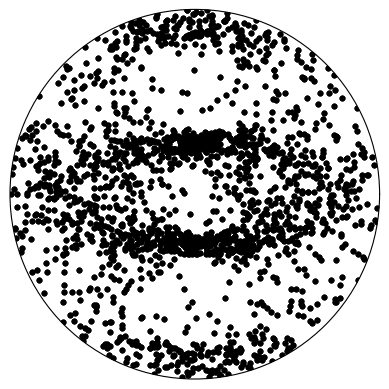

In [9]:
neml2.postprocessing.pretty_plot_pole_figure_points(orientations, torch.tensor([1,1,1.0], device = device), crystal_symmetry = "432")

In [10]:
odf = neml2.postprocessing.odf.KDEODF(orientations, neml2.postprocessing.odf.DeLaValleePoussinKernel(torch.tensor(0.2)))
#odf.optimize_kernel(verbose = True, miter = 1000)

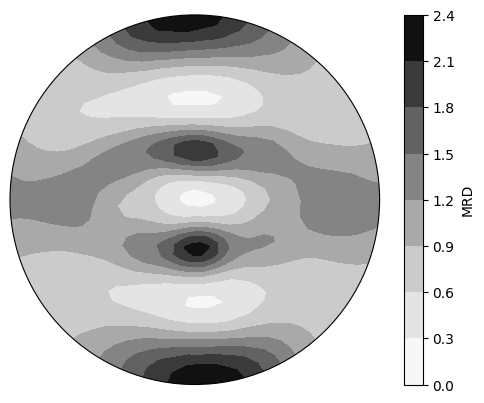

In [17]:
neml2.postprocessing.pretty_plot_pole_figure_odf(odf, torch.tensor([1,1,1.0], device = device), crystal_symmetry = "432")